In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split, ShuffleSplit, GridSearchCV, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import time
from itertools import product
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import joblib  # 모델 저장을 위한 라이브러리

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [2]:
def calculate_metrics(y_true, y_pred, training_time):
	"""평가 지표 계산 함수"""
	return {
		'MAE': mean_absolute_error(y_true, y_pred),
		'MSE': mean_squared_error(y_true, y_pred),
		'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
		'R2': r2_score(y_true, y_pred),
		'RMSLE': np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))),
		'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
		'Training_Time': training_time
	}

In [3]:
def calculate_direction_accuracy(y_true, y_pred):
    """
    상승/하락 예측 정확도 계산 함수.
    실제 값과 예측 값의 변동 방향이 일치하는 경우를 계산.
    """
    actual_direction = np.sign(y_true[1:].values - y_true[:-1].values)  # 실제 상승/하락 (-1, 0, 1)
    predicted_direction = np.sign(y_pred[1:] - y_pred[:-1])  # 예측 상승/하락 (-1, 0, 1)

    correct_predictions = np.sum(actual_direction == predicted_direction)
    total_predictions = len(actual_direction)

    accuracy = correct_predictions / total_predictions * 100  # 백분율 변환
    return accuracy

### 광어 

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [260],
		'max_depth': [8],
		'learning_rate': [0.1],
		'num_leaves': [9],
		'min_child_samples': [ 7],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

In [6]:

def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [260],
		'max_depth': [8],
		'learning_rate': [0.1],
		'num_leaves': [9],
		'min_child_samples': [ 7],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names_광어.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# # 예측 및 시각화
	y_pred = grid_search.predict(X)


	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")

	# 모델 평가 코드 내에서 추가
	direction_accuracy = calculate_direction_accuracy(y, y_pred)
	print(f"\n상승/하락 예측 정확도: {direction_accuracy:.2f}%")

	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5553
[LightGBM] [Info] Number of data points in the train set: 26261, number of used features: 32
[LightGBM] [Info] Start training from score 35918.308899
2.222447395324707

** Model Performance **
Best RMSE: 1139.4691

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.1
max_depth: 8
min_child_samples: 7
n_estimators: 260
n_jobs: -1
num_leaves: 9
random_state: 1030
subsample: 0.9

Final Metrics:
MAE: 306.1630
MSE: 419884.3656
RMSE: 647.9848
R2: 0.9828
RMSLE: 0.0178
MAPE: 0.8457
Training_Time: 2.2224

상승/하락 예측 정확도: 85.08%

** Market-wise Metrics **
m_가락시장: RMSE = 541.2379, R2 = 0.9873, MAE = 286.4411, MAPE = 0.7586
m_강서농수산물시장: RMSE = 879.8919, R2 = 0.9842, MAE = 532.4880, MAPE = 1.3241
m_구리농수산물시장: RMSE = 994.2777, R2 = 0.8485, MAE = 40

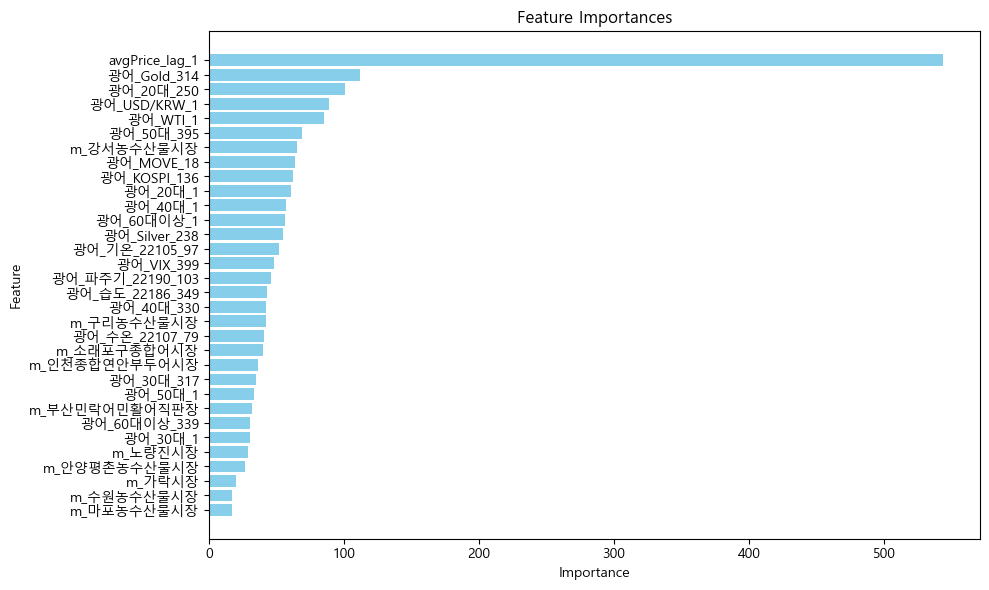

LGBMRegressor(colsample_bytree=0.9, max_depth=8, min_child_samples=7,
              n_estimators=260, n_jobs=-1, num_leaves=9, random_state=1030,
              subsample=0.9)

학습된 모델이 'lgbm_광어.joblib'로 저장되었습니다.


In [7]:
data = pd.read_csv('../../data/features/final_oneHot/광어_price_features_notnull.csv')
exclude_features = [

     ]

model_광어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features, time_series=True)

print(model_광어)

# 학습된 모델 저장
joblib.dump(model_광어, 'lgbm_광어.joblib')  
# 사용한 피처 리스트 저장
feature_names = model_광어.feature_name_
joblib.dump(feature_names, 'feature_names_광어.pkl')
print("\n학습된 모델이 'lgbm_광어.joblib'로 저장되었습니다.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4110
[LightGBM] [Info] Number of data points in the train set: 1313, number of used features: 28
[LightGBM] [Info] Start training from score 31918.667174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5170
[LightGBM] [Info] Number of data points in the train set: 2626, number of used features: 28
[LightGBM] [Info] Start training from score 33527.528561
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5317
[LightGBM] [Info] Number of data points in the train set: 3939, number of used features: 31
[LightGBM] [Info] Star

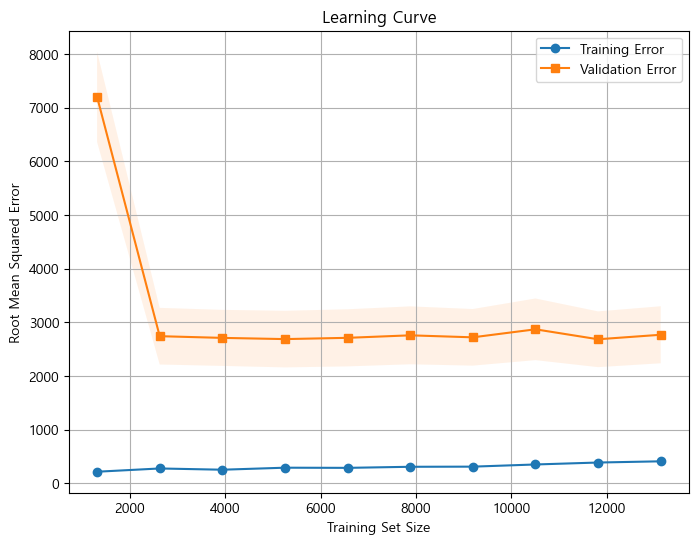

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5553
[LightGBM] [Info] Number of data points in the train set: 26261, number of used features: 32
[LightGBM] [Info] Start training from score 35918.308899
1.8548591136932373

** Model Performance **
Best RMSE: 1139.4691

학습된 모델이 'lgbm_광어.joblib'로 저장되었습니다.


In [42]:
def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	
	# 학습 곡선 그리기
	train_sizes, train_scores, test_scores = learning_curve(
	    lgbm, X, y, cv=cv, scoring='neg_root_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
	)
	
	# 학습 곡선 시각화
	train_mean = -np.mean(train_scores, axis=1)
	train_std = np.std(train_scores, axis=1)
	test_mean = -np.mean(test_scores, axis=1)
	test_std = np.std(test_scores, axis=1)

	plt.figure(figsize=(8, 6))
	plt.plot(train_sizes, train_mean, 'o-', label="Training Error")
	plt.plot(train_sizes, test_mean, 's-', label="Validation Error")
	plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
	plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
	plt.xlabel("Training Set Size")
	plt.ylabel("Root Mean Squared Error")
	plt.title("Learning Curve")
	plt.legend()
	plt.grid()
	plt.show()

	# GridSearchCV로 모델 학습
	grid_search = GridSearchCV(
		lgbm, {
			'n_estimators': [260],
			'max_depth': [8],
			'learning_rate': [0.1],
			'num_leaves': [9],
			'min_child_samples': [7],
			'subsample': [0.9],
			'colsample_bytree': [0.9],
			'random_state': [1030],
			'n_jobs': [-1]
		},
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names_광어.pkl')

	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")

	# 학습된 모델 반환
	return grid_search.best_estimator_

# 데이터 불러오기
data = pd.read_csv('../../data/features/final_oneHot/광어_price_features_notnull.csv')
model_광어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=[])

# 학습된 모델 저장
joblib.dump(model_광어, 'lgbm_광어.joblib')
print("\n학습된 모델이 'lgbm_광어.joblib'로 저장되었습니다.")

### 농어

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [ 100],
		'max_depth': [6],
		'learning_rate': [0.1],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

In [40]:

def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [100],
		'max_depth': [6],
		'learning_rate': [0.1],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//20
		cv = TimeSeriesSplit(n_splits=10, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names_농어.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# 예측 및 시각화
	y_pred = grid_search.predict(X)
	# plt.figure(figsize=(15, 7))
	# plt.plot(data['date'], y, label='Actual', color='blue')
	# plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
	# plt.title('Actual vs Predicted Price')
	# plt.xlabel('Date')
	# plt.ylabel('Price')
	# plt.legend()
	# plt.grid(True)
	# plt.xticks(rotation=45)
	# plt.tight_layout()
	# plt.show()

	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

			# # 그래프 생성
			# plt.figure(figsize=(15, 7))
			# plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
			# plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
			# plt.title(f'Actual vs Predicted Price ({col})')
			# plt.xlabel('Date')
			# plt.ylabel('Price')
			# plt.legend()
			# plt.grid(True)
			# plt.xticks(rotation=45)								
			# plt.tight_layout()
			# plt.show()


	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")

	# 모델 평가 코드 내에서 추가
	direction_accuracy = calculate_direction_accuracy(y, y_pred)
	print(f"\n상승/하락 예측 정확도: {direction_accuracy:.2f}%")

	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5562
[LightGBM] [Info] Number of data points in the train set: 25023, number of used features: 31
[LightGBM] [Info] Start training from score 36142.972066
2.6785318851470947

** Model Performance **
Best RMSE: 1296.2797

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.1
max_depth: 6
min_child_samples: 6
n_estimators: 100
n_jobs: -1
num_leaves: 8
random_state: 1030
subsample: 0.9

Final Metrics:
MAE: 413.2862
MSE: 727533.4130
RMSE: 852.9557
R2: 0.9702
RMSLE: 0.0230
MAPE: 1.1209
Training_Time: 2.6785

상승/하락 예측 정확도: 89.52%

** Market-wise Metrics **
m_가락시장: RMSE = 750.7599, R2 = 0.9775, MAE = 377.9599, MAPE = 1.0587
m_강서농수산물시장: RMSE = 989.4383, R2 = 0.9704, MAE = 610.7351, MAPE = 1.6868
m_구리농수산물시장: RMSE = 1042.7442, R2 = 0.9484, MAE 

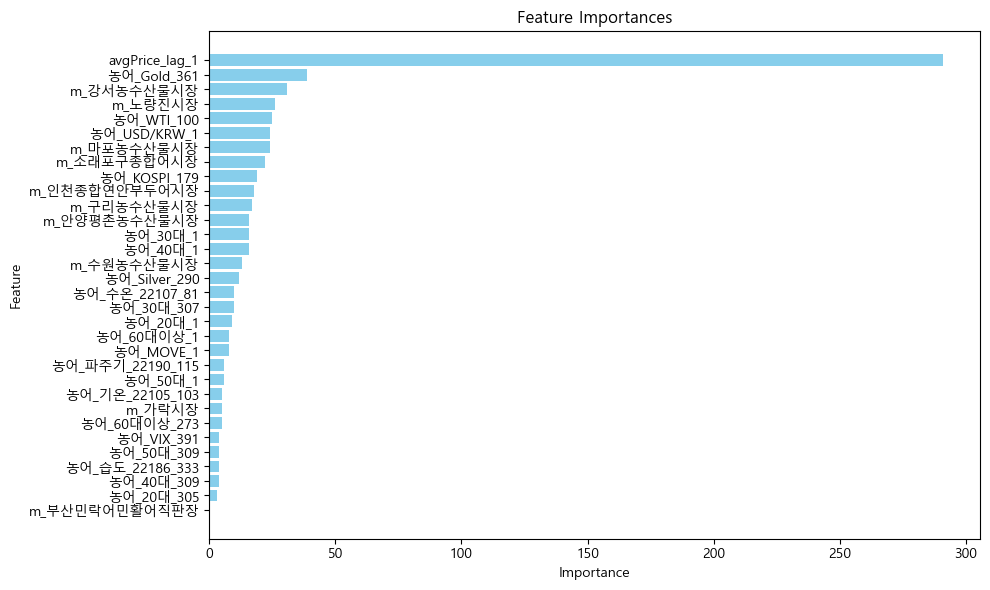

LGBMRegressor(colsample_bytree=0.9, max_depth=6, min_child_samples=6, n_jobs=-1,
              num_leaves=8, random_state=1030, subsample=0.9)

학습된 모델이 'lgbm_농어.joblib'로 저장되었습니다.


In [41]:
data = pd.read_csv('../../data/features/final_oneHot/농어_price_features_notnull.csv')


exclude_features = [

	
	]
model_농어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features, time_series=True)

print(model_농어)

# 학습된 모델 저장
joblib.dump(model_농어, 'lgbm_농어.joblib')  # 모델을 'xgb_model.joblib' 파일에 저장

print("\n학습된 모델이 'lgbm_농어.joblib'로 저장되었습니다.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 1251, number of used features: 28
[LightGBM] [Info] Start training from score 31532.861711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4995
[LightGBM] [Info] Number of data points in the train set: 2502, number of used features: 29
[LightGBM] [Info] Start training from score 32185.539568
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was

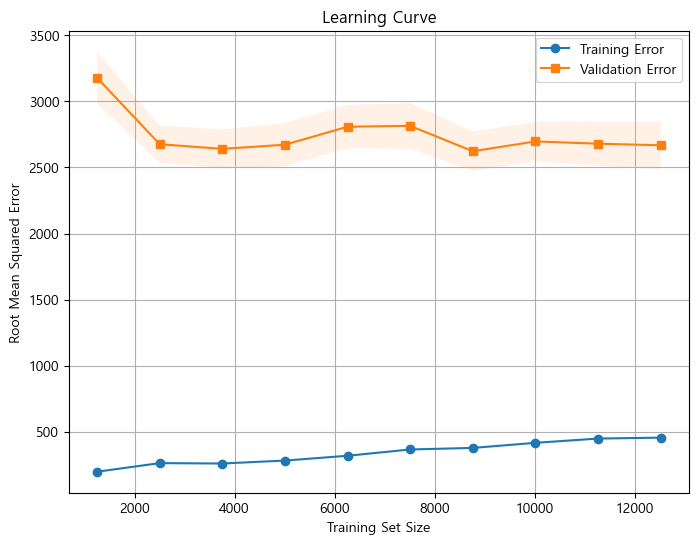

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5562
[LightGBM] [Info] Number of data points in the train set: 25023, number of used features: 31
[LightGBM] [Info] Start training from score 36142.972066
1.8868789672851562

** Model Performance **
Best RMSE: 1477.4112

학습된 모델이 'lgbm_농어.joblib'로 저장되었습니다.


In [43]:
def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	
	# 학습 곡선 그리기
	train_sizes, train_scores, test_scores = learning_curve(
	    lgbm, X, y, cv=cv, scoring='neg_root_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
	)
	
	# 학습 곡선 시각화
	train_mean = -np.mean(train_scores, axis=1)
	train_std = np.std(train_scores, axis=1)
	test_mean = -np.mean(test_scores, axis=1)
	test_std = np.std(test_scores, axis=1)

	plt.figure(figsize=(8, 6))
	plt.plot(train_sizes, train_mean, 'o-', label="Training Error")
	plt.plot(train_sizes, test_mean, 's-', label="Validation Error")
	plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
	plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
	plt.xlabel("Training Set Size")
	plt.ylabel("Root Mean Squared Error")
	plt.title("Learning Curve")
	plt.legend()
	plt.grid()
	plt.show()

	# GridSearchCV로 모델 학습
	grid_search = GridSearchCV(
		lgbm, {
			'n_estimators': [260],
			'max_depth': [8],
			'learning_rate': [0.1],
			'num_leaves': [9],
			'min_child_samples': [7],
			'subsample': [0.9],
			'colsample_bytree': [0.9],
			'random_state': [1030],
			'n_jobs': [-1]
		},
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names_농어.pkl')

	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")

	# 학습된 모델 반환
	return grid_search.best_estimator_

# 데이터 불러오기
data = pd.read_csv('../../data/features/final_oneHot/농어_price_features_notnull.csv')
model_광어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=[])

# 학습된 모델 저장
joblib.dump(model_광어, 'lgbm_농어.joblib')
print("\n학습된 모델이 'lgbm_농어.joblib'로 저장되었습니다.")

### 대게

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [90],
		'max_depth': [7],
		'learning_rate': [0.1],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

In [10]:
def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [90],
		'max_depth': [7],
		'learning_rate': [0.1],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//20
		cv = TimeSeriesSplit(n_splits=10, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# 예측 및 시각화
	y_pred = grid_search.predict(X)
	# plt.figure(figsize=(15, 7))
	# plt.plot(data['date'], y, label='Actual', color='blue')
	# plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
	# plt.title('Actual vs Predicted Price')
	# plt.xlabel('Date')
	# plt.ylabel('Price')
	# plt.legend()
	# plt.grid(True)
	# plt.xticks(rotation=45)
	# plt.tight_layout()
	# plt.show()

	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

			# # 그래프 생성
			# plt.figure(figsize=(15, 7))
			# plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
			# plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
			# plt.title(f'Actual vs Predicted Price ({col})')
			# plt.xlabel('Date')
			# plt.ylabel('Price')
			# plt.legend()
			# plt.grid(True)
			# plt.xticks(rotation=45)								
			# plt.tight_layout()
			# plt.show()


	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")

	# 모델 평가 코드 내에서 추가
	direction_accuracy = calculate_direction_accuracy(y, y_pred)
	print(f"\n상승/하락 예측 정확도: {direction_accuracy:.2f}%")		


	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5115
[LightGBM] [Info] Number of data points in the train set: 21281, number of used features: 28
[LightGBM] [Info] Start training from score 56154.152061
1.5584275722503662

** Model Performance **
Best RMSE: 2363.3725

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.1
max_depth: 7
min_child_samples: 6
n_estimators: 90
n_jobs: -1
num_leaves: 8
random_state: 1030
subsample: 0.9

Final Metrics:
MAE: 990.7992
MSE: 3832491.2603
RMSE: 1957.6750
R2: 0.9768
RMSLE: 0.0360
MAPE: 1.8422
Training_Time: 1.5584

상승/하락 예측 정확도: 92.75%

** Market-wise Metrics **
m_가락시장: RMSE = 2232.9588, R2 = 0.9661, MAE = 1060.6322, MAPE = 1.7259
m_강서농수산물시장: RMSE = 1505.8466, R2 = 0.9840, MAE = 814.7432, MAPE = 1.6043
m_구리농수산물시장: RMSE = 2451.1897, R2 = 0.9559, 

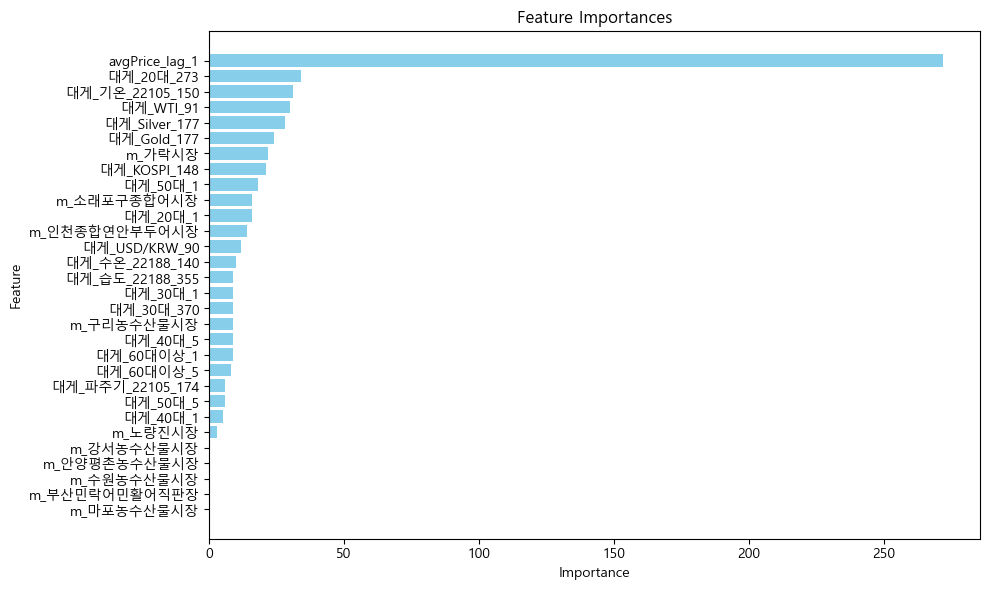

LGBMRegressor(colsample_bytree=0.9, max_depth=7, min_child_samples=6,
              n_estimators=90, n_jobs=-1, num_leaves=8, random_state=1030,
              subsample=0.9)

학습된 모델이 'lgbm_대게.joblib'로 저장되었습니다.


In [11]:
data = pd.read_csv('../../data/features/final_oneHot/대게_price_features_notnull.csv')


exclude_features = [

]
model_대게 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features, time_series=True)

print(model_대게)

# 학습된 모델 저장
joblib.dump(model_대게, 'lgbm_대게.joblib')  # 모델을 'xgb_model.joblib' 파일에 저장

print("\n학습된 모델이 'lgbm_대게.joblib'로 저장되었습니다.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3632
[LightGBM] [Info] Number of data points in the train set: 1064, number of used features: 26
[LightGBM] [Info] Start training from score 40073.590226
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4677
[LightGBM] [Info] Number of data points in the train set: 2128, number of used features: 26
[LightGBM] [Info] Start training from score 44507.565789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5013
[LightGBM] [Info] Number of data points in the train set: 3192, number of used features: 26
[LightGBM] [Info] Star

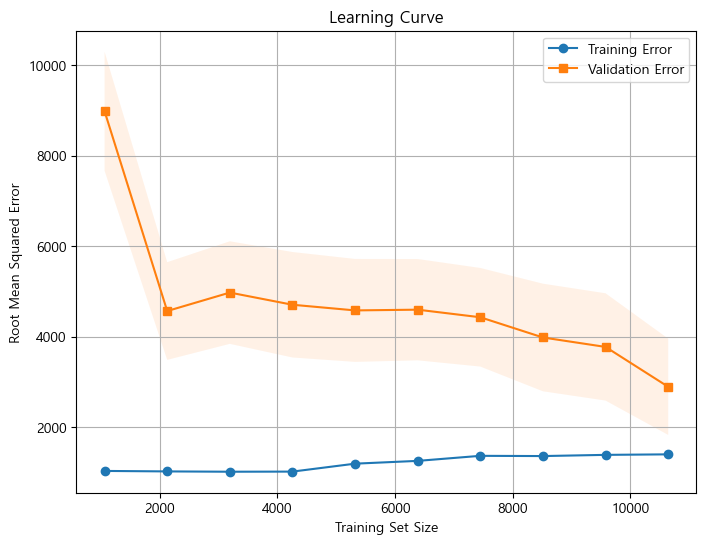

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5115
[LightGBM] [Info] Number of data points in the train set: 21281, number of used features: 28
[LightGBM] [Info] Start training from score 56154.152061
1.2586817741394043

** Model Performance **
Best RMSE: 2584.4038

학습된 모델이 'lgbm_대게.joblib'로 저장되었습니다.


In [44]:
def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	
	# 학습 곡선 그리기
	train_sizes, train_scores, test_scores = learning_curve(
	    lgbm, X, y, cv=cv, scoring='neg_root_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
	)
	
	# 학습 곡선 시각화
	train_mean = -np.mean(train_scores, axis=1)
	train_std = np.std(train_scores, axis=1)
	test_mean = -np.mean(test_scores, axis=1)
	test_std = np.std(test_scores, axis=1)

	plt.figure(figsize=(8, 6))
	plt.plot(train_sizes, train_mean, 'o-', label="Training Error")
	plt.plot(train_sizes, test_mean, 's-', label="Validation Error")
	plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
	plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
	plt.xlabel("Training Set Size")
	plt.ylabel("Root Mean Squared Error")
	plt.title("Learning Curve")
	plt.legend()
	plt.grid()
	plt.show()

	# GridSearchCV로 모델 학습
	grid_search = GridSearchCV(
		lgbm, {
			'n_estimators': [260],
			'max_depth': [8],
			'learning_rate': [0.1],
			'num_leaves': [9],
			'min_child_samples': [7],
			'subsample': [0.9],
			'colsample_bytree': [0.9],
			'random_state': [1030],
			'n_jobs': [-1]
		},
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names_대게.pkl')

	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")

	# 학습된 모델 반환
	return grid_search.best_estimator_

# 데이터 불러오기
data = pd.read_csv('../../data/features/final_oneHot/대게_price_features_notnull.csv')
model_광어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=[])

# 학습된 모델 저장
joblib.dump(model_광어, 'lgbm_대게.joblib')
print("\n학습된 모델이 'lgbm_대게.joblib'로 저장되었습니다.")

### 방어

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [45],
		'max_depth': [2],
		'learning_rate': [0.11],
		'num_leaves': [4],
		'min_child_samples': [7],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}


In [12]:

def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [45],
		'max_depth': [2],
		'learning_rate': [0.11],
		'num_leaves': [4],
		'min_child_samples': [7],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//20
		cv = TimeSeriesSplit(n_splits=10, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# 예측 및 시각화
	y_pred = grid_search.predict(X)
	# plt.figure(figsize=(15, 7))
	# plt.plot(data['date'], y, label='Actual', color='blue')
	# plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
	# plt.title('Actual vs Predicted Price')
	# plt.xlabel('Date')
	# plt.ylabel('Price')
	# plt.legend()
	# plt.grid(True)
	# plt.xticks(rotation=45)
	# plt.tight_layout()
	# plt.show()

	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

			# # 그래프 생성
			# plt.figure(figsize=(15, 7))
			# plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
			# plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
			# plt.title(f'Actual vs Predicted Price ({col})')
			# plt.xlabel('Date')
			# plt.ylabel('Price')
			# plt.legend()
			# plt.grid(True)
			# plt.xticks(rotation=45)								
			# plt.tight_layout()
			# plt.show()


	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")

	# 모델 평가 코드 내에서 추가
	direction_accuracy = calculate_direction_accuracy(y, y_pred)
	print(f"\n상승/하락 예측 정확도: {direction_accuracy:.2f}%")
	

	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3415
[LightGBM] [Info] Number of data points in the train set: 9526, number of used features: 22
[LightGBM] [Info] Start training from score 36486.538946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.23558521270751953

** Model Performance **
Best RMSE: 905.3227

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.11
max_depth: 2
min_child_samples: 7
n_estimators: 45
n_jobs: -1
num_leaves: 4
random_state: 1030
subsample: 0.9

Final Metrics:
MAE: 217.3781
MSE: 886461.0691
RMSE: 941.5206
R2: 0.9846
RMSLE: 0.0255
MAPE: 0.5947
Training_Time: 0.2356

상승/하락 예측 정확

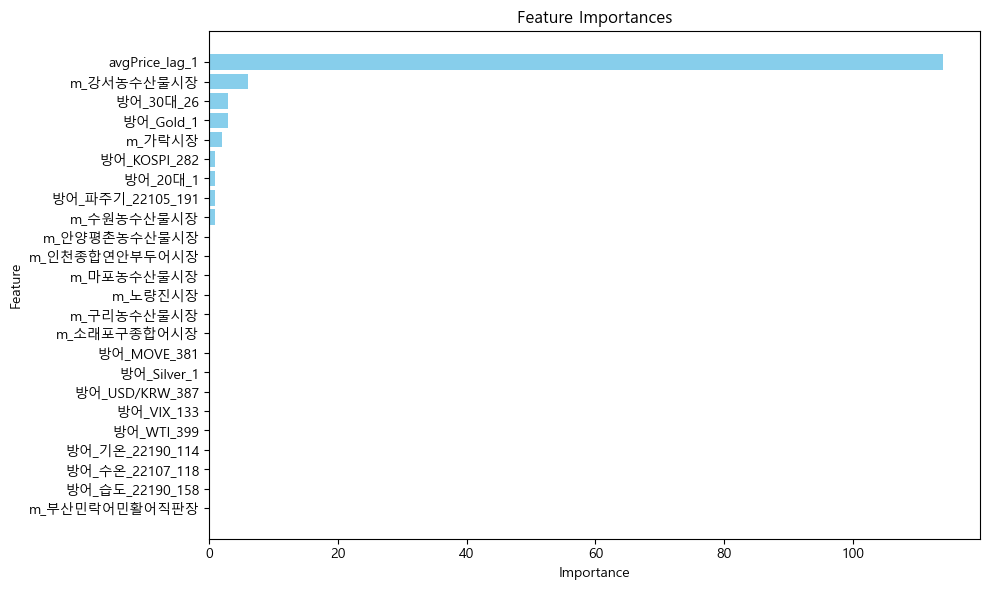

LGBMRegressor(colsample_bytree=0.9, learning_rate=0.11, max_depth=2,
              min_child_samples=7, n_estimators=45, n_jobs=-1, num_leaves=4,
              random_state=1030, subsample=0.9)

학습된 모델이 'lgbm_방어.joblib'로 저장되었습니다.


In [13]:
data = pd.read_csv('../../data/features/final_oneHot/방어_price_features_notnull.csv')

exclude_features = [
       '방어_60대이상_26',
        '방어_60대이상_1',
        '방어_50대_256',
          '방어_50대_1',
          '방어_40대_1',
          '방어_30대_1',
         '방어_20대_22',
        '방어_40대_256'
]
model_방어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features, time_series=True)

print(model_방어)

# 학습된 모델 저장
joblib.dump(model_방어, 'lgbm_방어.joblib')  # 모델을 'xgb_model.joblib' 파일에 저장

print("\n학습된 모델이 'lgbm_방어.joblib'로 저장되었습니다.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 476, number of used features: 28
[LightGBM] [Info] Start training from score 32947.289916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

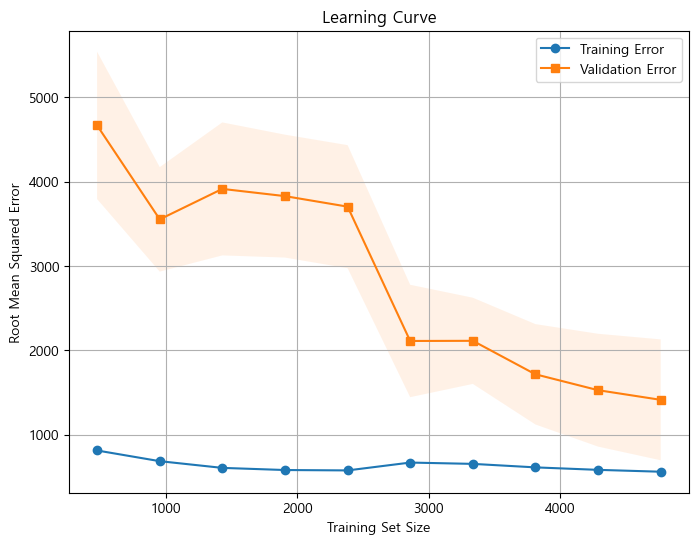

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5455
[LightGBM] [Info] Number of data points in the train set: 9526, number of used features: 30
[LightGBM] [Info] Start training from score 36486.538946
1.0728096961975098

** Model Performance **
Best RMSE: 1416.1198

학습된 모델이 'lgbm_방어.joblib'로 저장되었습니다.


In [45]:
def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	
	# 학습 곡선 그리기
	train_sizes, train_scores, test_scores = learning_curve(
	    lgbm, X, y, cv=cv, scoring='neg_root_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
	)
	
	# 학습 곡선 시각화
	train_mean = -np.mean(train_scores, axis=1)
	train_std = np.std(train_scores, axis=1)
	test_mean = -np.mean(test_scores, axis=1)
	test_std = np.std(test_scores, axis=1)

	plt.figure(figsize=(8, 6))
	plt.plot(train_sizes, train_mean, 'o-', label="Training Error")
	plt.plot(train_sizes, test_mean, 's-', label="Validation Error")
	plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
	plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
	plt.xlabel("Training Set Size")
	plt.ylabel("Root Mean Squared Error")
	plt.title("Learning Curve")
	plt.legend()
	plt.grid()
	plt.show()

	# GridSearchCV로 모델 학습
	grid_search = GridSearchCV(
		lgbm, {
			'n_estimators': [260],
			'max_depth': [8],
			'learning_rate': [0.1],
			'num_leaves': [9],
			'min_child_samples': [7],
			'subsample': [0.9],
			'colsample_bytree': [0.9],
			'random_state': [1030],
			'n_jobs': [-1]
		},
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names_방어.pkl')

	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")

	# 학습된 모델 반환
	return grid_search.best_estimator_

# 데이터 불러오기
data = pd.read_csv('../../data/features/final_oneHot/방어_price_features_notnull.csv')
model_광어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=[])

# 학습된 모델 저장
joblib.dump(model_광어, 'lgbm_방어.joblib')
print("\n학습된 모델이 'lgbm_방어.joblib'로 저장되었습니다.")

### 연어

#### 노르웨이 제외 OO

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [60],
		'max_depth': [7],
		'learning_rate': [0.09],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

In [17]:
def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [60],
		'max_depth': [7],
		'learning_rate': [0.09],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//20
		cv = TimeSeriesSplit(n_splits=10, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# 예측 및 시각화
	y_pred = grid_search.predict(X)
	# plt.figure(figsize=(15, 7))
	# plt.plot(data['date'], y, label='Actual', color='blue')
	# plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
	# plt.title('Actual vs Predicted Price')
	# plt.xlabel('Date')
	# plt.ylabel('Price')
	# plt.legend()
	# plt.grid(True)
	# plt.xticks(rotation=45)
	# plt.tight_layout()
	# plt.show()

	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

			# # 그래프 생성
			# plt.figure(figsize=(15, 7))
			# plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
			# plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
			# plt.title(f'Actual vs Predicted Price ({col})')
			# plt.xlabel('Date')
			# plt.ylabel('Price')
			# plt.legend()
			# plt.grid(True)
			# plt.xticks(rotation=45)								
			# plt.tight_layout()
			# plt.show()


	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")

	# 모델 평가 코드 내에서 추가
	direction_accuracy = calculate_direction_accuracy(y, y_pred)
	print(f"\n상승/하락 예측 정확도: {direction_accuracy:.2f}%")

	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3509
[LightGBM] [Info] Number of data points in the train set: 23741, number of used features: 23
[LightGBM] [Info] Start training from score 4769.059854
0.5485472679138184

** Model Performance **
Best RMSE: 371.1969

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.09
max_depth: 7
min_child_samples: 6
n_estimators: 60
n_jobs: -1
num_leaves: 8
random_state: 1030
subsample: 0.9

Final Metrics:
MAE: 87.3412
MSE: 41659.0869
RMSE: 204.1056
R2: 0.9757
RMSLE: 0.0360
MAPE: 1.7181
Training_Time: 0.5485

상승/하락 예측 정확도: 90.78%

** Market-wise Metrics **
m_가락시장: RMSE = 298.2498, R2 = 0.9305, MAE = 150.4127, MAPE = 2.5053
m_강서농수산물시장: RMSE = 201.5837, R2 = 0.9725, MAE = 129.2624, MAPE = 2.7688
m_구리농수산물시장: RMSE = 124.5759, R2 = 0.9872, MAE = 45.

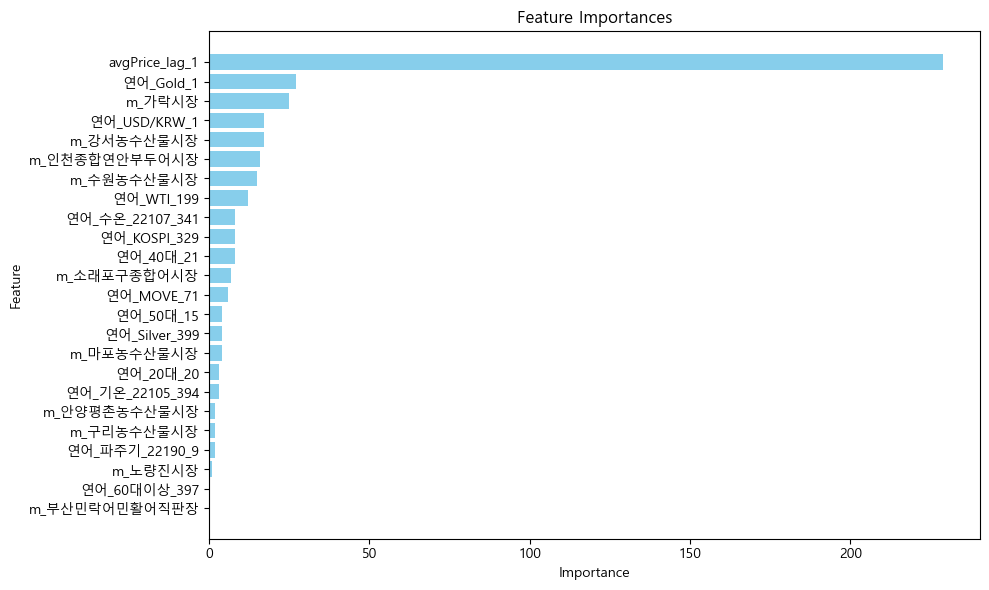

LGBMRegressor(colsample_bytree=0.9, learning_rate=0.09, max_depth=7,
              min_child_samples=6, n_estimators=60, n_jobs=-1, num_leaves=8,
              random_state=1030, subsample=0.9)

학습된 모델이 'lgbm_연어.joblib'로 저장되었습니다.


In [18]:
data = pd.read_csv('../../data/features/final_oneHot/연어_price_features_notnull_노르웨이제외.csv')

exclude_features = [
       '연어_60대이상_1',
          '연어_50대_1',
        '연어_VIX_399',
     '연어_습도_22105_8',

     '연어_30대_1',
     '연어_40대_1',
     '연어_20대_1',
     '연어_30대_15'

]
model_연어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features, time_series=True)

print(model_연어)

# 학습된 모델 저장
joblib.dump(model_연어, 'lgbm_연어.joblib')  # 모델을 'xgb_model.joblib' 파일에 저장

print("\n학습된 모델이 'lgbm_연어.joblib'로 저장되었습니다.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3531
[LightGBM] [Info] Number of data points in the train set: 1187, number of used features: 28
[LightGBM] [Info] Start training from score 3717.270430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5248
[LightGBM] [Info] Number of data points in the train set: 2374, number of used features: 28
[LightGBM] [Info] Start training from score 3700.964617
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5381
[LightGBM] [Info] Number of data points i

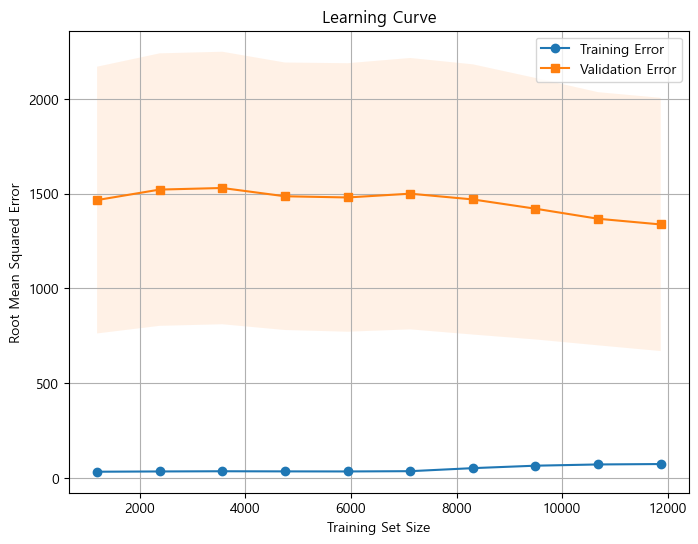

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5549
[LightGBM] [Info] Number of data points in the train set: 23741, number of used features: 31
[LightGBM] [Info] Start training from score 4769.059854
1.9642081260681152

** Model Performance **
Best RMSE: 564.3289

학습된 모델이 'lgbm_연어.joblib'로 저장되었습니다.


In [48]:
def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	
	# 학습 곡선 그리기
	train_sizes, train_scores, test_scores = learning_curve(
	    lgbm, X, y, cv=cv, scoring='neg_root_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
	)
	
	# 학습 곡선 시각화
	train_mean = -np.mean(train_scores, axis=1)
	train_std = np.std(train_scores, axis=1)
	test_mean = -np.mean(test_scores, axis=1)
	test_std = np.std(test_scores, axis=1)

	plt.figure(figsize=(8, 6))
	plt.plot(train_sizes, train_mean, 'o-', label="Training Error")
	plt.plot(train_sizes, test_mean, 's-', label="Validation Error")
	plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
	plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
	plt.xlabel("Training Set Size")
	plt.ylabel("Root Mean Squared Error")
	plt.title("Learning Curve")
	plt.legend()
	plt.grid()
	plt.show()

	# GridSearchCV로 모델 학습
	grid_search = GridSearchCV(
		lgbm, {
			'n_estimators': [260],
			'max_depth': [8],
			'learning_rate': [0.1],
			'num_leaves': [9],
			'min_child_samples': [7],
			'subsample': [0.9],
			'colsample_bytree': [0.9],
			'random_state': [1030],
			'n_jobs': [-1]
		},
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names_연어.pkl')

	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")

	# 학습된 모델 반환
	return grid_search.best_estimator_

# 데이터 불러오기
data = pd.read_csv('../../data/features/final_oneHot/연어_price_features_notnull_노르웨이제외.csv')
model_광어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=[])

# 학습된 모델 저장
joblib.dump(model_광어, 'lgbm_연어.joblib')
print("\n학습된 모델이 'lgbm_연어.joblib'로 저장되었습니다.")

### 우럭

    #250128 기준 확정 
    lgbm_params = {
        
        'n_estimators': [ 105 ],
        'max_depth': [3],
        'learning_rate': [0.1],
        'num_leaves': [4],
        'min_child_samples': [8],
        'subsample': [0.9],
        'colsample_bytree': [0.9],
        'random_state': [1030],
        'n_jobs': [-1]
    }

In [19]:
def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250128 기준 확정 
	lgbm_params = {
        'n_estimators': [ 105 ],
        'max_depth': [3],
        'learning_rate': [0.1],
        'num_leaves': [4],
        'min_child_samples': [8],
        'subsample': [0.9],
        'colsample_bytree': [0.9],
        'random_state': [1030],
        'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//20
		cv = TimeSeriesSplit(n_splits=10, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# 예측 및 시각화
	y_pred = grid_search.predict(X)
	# plt.figure(figsize=(15, 7))
	# plt.plot(data['date'], y, label='Actual', color='blue')
	# plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
	# plt.title('Actual vs Predicted Price')
	# plt.xlabel('Date')
	# plt.ylabel('Price')
	# plt.legend()
	# plt.grid(True)
	# plt.xticks(rotation=45)
	# plt.tight_layout()
	# plt.show()

	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

			# # 그래프 생성
			# plt.figure(figsize=(15, 7))
			# plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
			# plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
			# plt.title(f'Actual vs Predicted Price ({col})')
			# plt.xlabel('Date')
			# plt.ylabel('Price')
			# plt.legend()
			# plt.grid(True)
			# plt.xticks(rotation=45)								
			# plt.tight_layout()
			# plt.show()


	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")

	# 모델 평가 코드 내에서 추가
	direction_accuracy = calculate_direction_accuracy(y, y_pred)
	print(f"\n상승/하락 예측 정확도: {direction_accuracy:.2f}%")

	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3879
[LightGBM] [Info] Number of data points in the train set: 5325, number of used features: 26
[LightGBM] [Info] Start training from score 33547.233803
0.3798561096191406

** Model Performance **
Best RMSE: 850.4993

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.1
max_depth: 3
min_child_samples: 8
n_estimators: 105
n_jobs: -1
num_leaves: 4
random_state: 1030
subsample: 0.9

Final Metrics:
MAE: 481.2260
MSE: 894180.9756
RMSE: 945.6114
R2: 0.9447
RMSLE: 0.0289
MAPE: 1.4591
Training_Time: 0.3799

상승/하락 예측 정확도: 92.32%

** Market-wise Metrics **
m_가락시장: RMSE = 1089.2571, R2 = 0.4728, MAE = 530.6505, MAPE = 1.3903
m_강서농수산물시장: RMSE = 1059.6970, R2 = 0.1967, MAE = 830.0663, MAPE = 2.0018
m_구리농수산물시장: RMSE = 1055.7017, R2 = 0.1656, MAE 

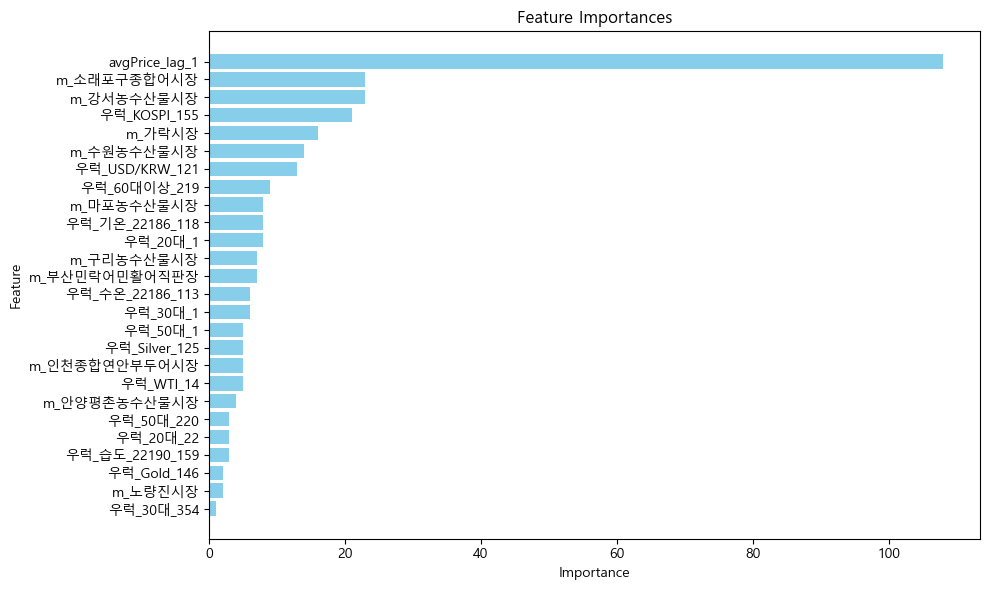

LGBMRegressor(colsample_bytree=0.9, max_depth=3, min_child_samples=8,
              n_estimators=105, n_jobs=-1, num_leaves=4, random_state=1030,
              subsample=0.9)
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.9, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 8, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 105, 'n_jobs': -1, 'num_leaves': 4, 'objective': None, 'random_state': 1030, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0}

학습된 모델이 'lgbm_우럭.joblib'로 저장되었습니다.


In [20]:
data = pd.read_csv('../../data/features/final_oneHot/우럭_price_features_notnull.csv')
exclude_features = [
'우럭_40대_1',
       '우럭_40대_354',
        '우럭_60대이상_1',   
  '우럭_파주기_22189_172', 
  '우럭_VIX_38'
    ]


model_우럭 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features)

print(model_우럭)
print(model_우럭.get_params())

# 학습된 모델 저장
joblib.dump(model_우럭, 'lgbm_우럭.joblib')  # 모델을 'xgb_model.joblib' 파일에 저장

print("\n학습된 모델이 'lgbm_우럭.joblib'로 저장되었습니다.")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 266, number of used features: 31
[LightGBM] [Info] Start training from score 33244.962406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

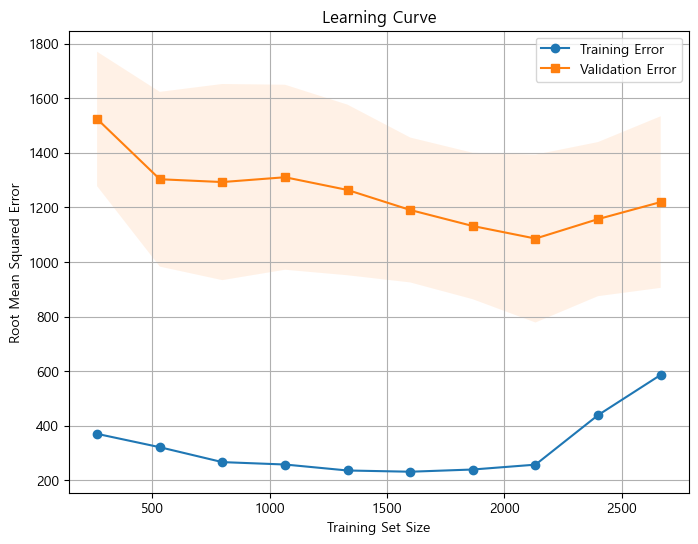

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5135
[LightGBM] [Info] Number of data points in the train set: 5325, number of used features: 31
[LightGBM] [Info] Start training from score 33547.233803
1.9188957214355469

** Model Performance **
Best RMSE: 1037.2352

학습된 모델이 'lgbm_우럭.joblib'로 저장되었습니다.


In [53]:
def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	
	# 학습 곡선 그리기
	train_sizes, train_scores, test_scores = learning_curve(
	    lgbm, X, y, cv=cv, scoring='neg_root_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
	)
	
	# 학습 곡선 시각화
	train_mean = -np.mean(train_scores, axis=1)
	train_std = np.std(train_scores, axis=1)
	test_mean = -np.mean(test_scores, axis=1)
	test_std = np.std(test_scores, axis=1)

	plt.figure(figsize=(8, 6))
	plt.plot(train_sizes, train_mean, 'o-', label="Training Error")
	plt.plot(train_sizes, test_mean, 's-', label="Validation Error")
	plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
	plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
	plt.xlabel("Training Set Size")
	plt.ylabel("Root Mean Squared Error")
	plt.title("Learning Curve")
	plt.legend()
	plt.grid()
	plt.show()

	# GridSearchCV로 모델 학습
	grid_search = GridSearchCV(
		lgbm, {
			'n_estimators': [260],
			'max_depth': [8],
			'learning_rate': [0.1],
			'num_leaves': [9],
			'min_child_samples': [7],
			'subsample': [0.9],
			'colsample_bytree': [0.9],
			'random_state': [11],
			'n_jobs': [-1]
		},
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names_우럭.pkl')

	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")

	# 학습된 모델 반환
	return grid_search.best_estimator_

# 데이터 불러오기
data = pd.read_csv('../../data/features/final_oneHot/우럭_price_features_notnull.csv')
model_광어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=[])

# 학습된 모델 저장
joblib.dump(model_광어, 'lgbm_우럭.joblib')
print("\n학습된 모델이 'lgbm_우럭.joblib'로 저장되었습니다.")

### 참돔

    #250128 기준 확정 
	lgbm_params = {
		'n_estimators': [90],
		'max_depth': [7],
		'learning_rate': [0.1],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

In [21]:
def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [90],
		'max_depth': [7],
		'learning_rate': [0.1],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//20
		cv = TimeSeriesSplit(n_splits=10, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# 예측 및 시각화
	y_pred = grid_search.predict(X)
	# plt.figure(figsize=(15, 7))
	# plt.plot(data['date'], y, label='Actual', color='blue')
	# plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
	# plt.title('Actual vs Predicted Price')
	# plt.xlabel('Date')
	# plt.ylabel('Price')
	# plt.legend()
	# plt.grid(True)
	# plt.xticks(rotation=45)
	# plt.tight_layout()
	# plt.show()

	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

			# # 그래프 생성
			# plt.figure(figsize=(15, 7))
			# plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
			# plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
			# plt.title(f'Actual vs Predicted Price ({col})')
			# plt.xlabel('Date')
			# plt.ylabel('Price')
			# plt.legend()
			# plt.grid(True)
			# plt.xticks(rotation=45)								
			# plt.tight_layout()
			# plt.show()


	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")

	# 모델 평가 코드 내에서 추가
	direction_accuracy = calculate_direction_accuracy(y, y_pred)
	print(f"\n상승/하락 예측 정확도: {direction_accuracy:.2f}%")

	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4754
[LightGBM] [Info] Number of data points in the train set: 23088, number of used features: 28
[LightGBM] [Info] Start training from score 37020.801715
0.7831315994262695

** Model Performance **
Best RMSE: 834.1810

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.1
max_depth: 7
min_child_samples: 6
n_estimators: 90
n_jobs: -1
num_leaves: 8
random_state: 1030
subsample: 0.9

Final Metrics:
MAE: 258.9995
MSE: 350365.9644
RMSE: 591.9172
R2: 0.9724
RMSLE: 0.0156
MAPE: 0.6859
Training_Time: 0.7831

상승/하락 예측 정확도: 86.36%

** Market-wise Metrics **
m_가락시장: RMSE = 553.2843, R2 = 0.9639, MAE = 295.5185, MAPE = 0.7769
m_강서농수산물시장: RMSE = 925.0789, R2 = 0.9578, MAE = 594.8743, MAPE = 1.4750
m_구리농수산물시장: RMSE = 212.2001, R2 = 0.9915, MAE = 6

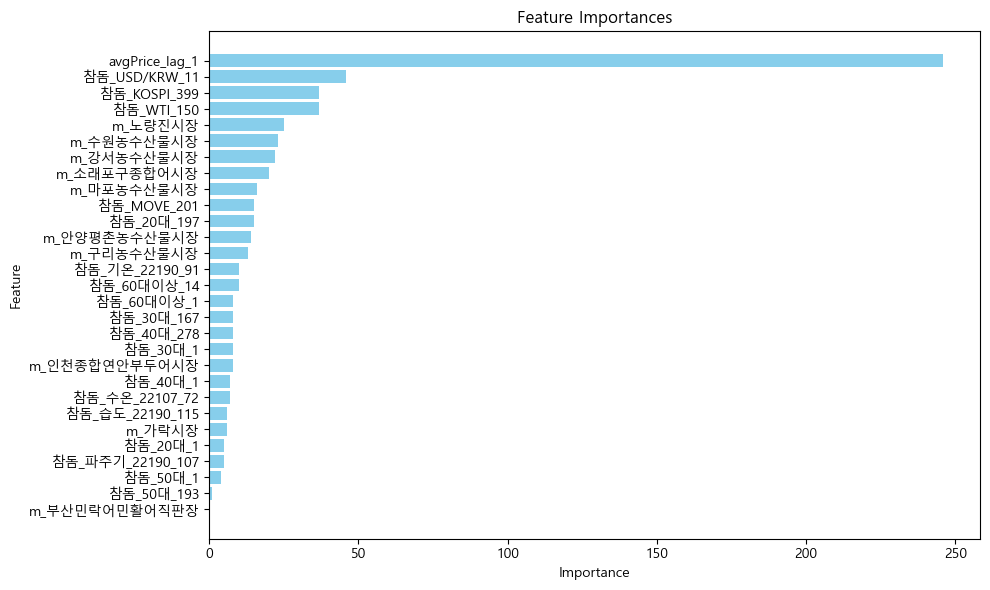

LGBMRegressor(colsample_bytree=0.9, max_depth=7, min_child_samples=6,
              n_estimators=90, n_jobs=-1, num_leaves=8, random_state=1030,
              subsample=0.9)

학습된 모델이 'lgbm_참돔.joblib'로 저장되었습니다.


In [22]:
data = pd.read_csv('../../data/features/final_oneHot/참돔_price_features_notnull.csv')


exclude_features = []
model_참돔 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features, time_series=True)

print(model_참돔)

# 학습된 모델 저장
joblib.dump(model_참돔, 'lgbm_참돔.joblib')  # 모델을 'xgb_model.joblib' 파일에 저장

print("\n학습된 모델이 'lgbm_참돔.joblib'로 저장되었습니다.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4281
[LightGBM] [Info] Number of data points in the train set: 1154, number of used features: 22
[LightGBM] [Info] Start training from score 35036.958406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4446
[LightGBM] [Info] Number of data points in the train set: 2309, number of used features: 24
[LightGBM] [Info] Start training from score 35577.674318
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4494
[LightGBM] [Info] Number of data points

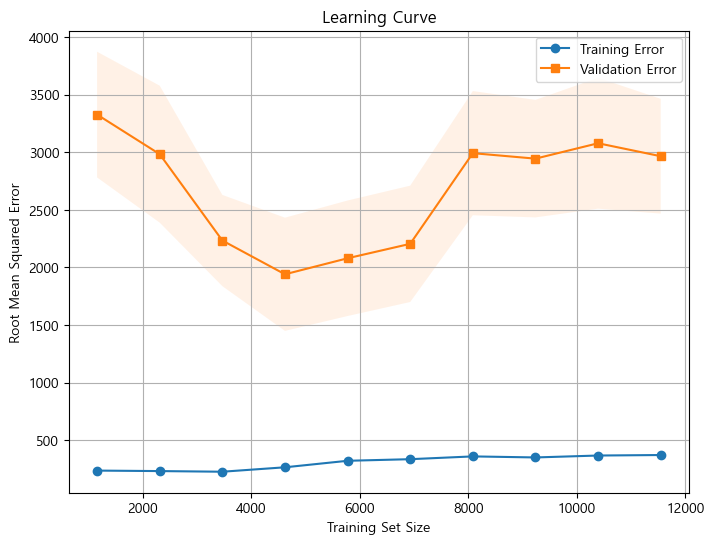

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4754
[LightGBM] [Info] Number of data points in the train set: 23088, number of used features: 28
[LightGBM] [Info] Start training from score 37020.801715
2.1649539470672607

** Model Performance **
Best RMSE: 1183.9188

학습된 모델이 'lgbm_참돔.joblib'로 저장되었습니다.


In [ ]:
def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	
	# 학습 곡선 그리기
	train_sizes, train_scores, test_scores = learning_curve(
	    lgbm, X, y, cv=cv, scoring='neg_root_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
	)
	
	# 학습 곡선 시각화
	train_mean = -np.mean(train_scores, axis=1)
	train_std = np.std(train_scores, axis=1)
	test_mean = -np.mean(test_scores, axis=1)
	test_std = np.std(test_scores, axis=1)

	plt.figure(figsize=(8, 6))
	plt.plot(train_sizes, train_mean, 'o-', label="Training Error")
	plt.plot(train_sizes, test_mean, 's-', label="Validation Error")
	plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
	plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
	plt.xlabel("Training Set Size")
	plt.ylabel("Root Mean Squared Error")
	plt.title("Learning Curve")
	plt.legend()
	plt.grid()
	plt.show()

	# GridSearchCV로 모델 학습
	grid_search = GridSearchCV(
		lgbm, {
			'n_estimators': [260],
			'max_depth': [8],
			'learning_rate': [0.1],
			'num_leaves': [9],
			'min_child_samples': [7],
			'subsample': [0.9],
			'colsample_bytree': [0.9],
			'random_state': [1030],
			'n_jobs': [-1]
		},
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names_참돔.pkl')

	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")

	# 학습된 모델 반환
	return grid_search.best_estimator_

# 데이터 불러오기
data = pd.read_csv('../../data/features/final_oneHot/참돔_price_features_notnull.csv')
model_광어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=[])

# 학습된 모델 저장
joblib.dump(model_광어, 'lgbm_참돔.joblib')
print("\n학습된 모델이 'lgbm_참돔.joblib'로 저장되었습니다.")

### 기타

#### 가격 예측 

In [36]:
# 저장된 모델 로드
loaded_model = joblib.load('lgbm_광어.joblib')
feature_names = joblib.load('feature_names_광어.pkl')
print("모델이 성공적으로 로드되었습니다.")

# 예측 데이터 준비
data = pd.read_csv('../../data/features/final_oneHot/광어_price_features_notnull.csv') 
X = data[feature_names]  # 학습 시 사용된 피처만 선택

# 결과 저장용 리스트
market_predictions = []

# 시장별 예측
markets = [
	"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
	"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장",
	"m_수원농수산물시장", "m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
]

for market in markets:
	# 시장별 데이터 필터링
	market_data = data[data[market] == 1]

	if not market_data.empty:  # 데이터가 존재할 경우에만 실행
		X = market_data[feature_names]  # 학습 시 사용된 피처만 선택
		y_pred = loaded_model.predict(X)  # 시장별 예측

		# 다음날 날짜 생성
		last_date = pd.to_datetime(market_data['date'].iloc[-1])  # 마지막 날짜
		next_date = last_date + pd.Timedelta(days=1)

		# 결과 저장
		market_predictions.append({
			'Market': market,
			'Next_Date': next_date.strftime('%Y-%m-%d'),
			'Predicted_Price': y_pred[-1]  # 가장 마지막 예측 값 (다음날 예측)
		})

# 결과 데이터프레임 생성
result_df = pd.DataFrame(market_predictions)

# 결과 출력
print("시장별 내일 가격 예측:")
print(result_df)

# # 결과 저장
# result_df.to_csv('market_predictions.csv', index=False)
# print("시장별 예측 결과가 'market_predictions.csv'에 저장되었습니다.")


모델이 성공적으로 로드되었습니다.
시장별 내일 가격 예측:
          Market   Next_Date  Predicted_Price
0         m_가락시장  2025-01-01     44886.105530
1     m_강서농수산물시장  2025-01-01     47416.696913
2     m_구리농수산물시장  2025-01-01     40192.957336
3        m_노량진시장  2025-01-01     39613.440779
4     m_마포농수산물시장  2025-01-01     44909.377370
5  m_부산민락어민활어직판장  2025-01-01     40631.911441
6    m_소래포구종합어시장  2025-01-01     40872.019019
7     m_수원농수산물시장  2025-01-01     41838.855798
8   m_안양평촌농수산물시장  2025-01-01     45065.396012
9  m_인천종합연안부두어시장  2025-01-01     38808.291745


def train_evaluate_lgbm_walk_forward(data, target_col='avgPrice', exclude_features=None, train_size=6000, test_size=300, step=5):
    """
    LightGBM 모델의 Walk-Forward (Blocking) 방식 평가 및 결과 시각화

    Args:
        data (pd.DataFrame): 학습 데이터
        target_col (str): 타겟 변수 이름
        exclude_features (list): 제외할 피처 리스트
        train_size (int): 고정된 훈련 데이터 크기
        test_size (int): 검증 데이터 크기
        step (int): Walk-Forward 분할 간격
    """
    # 데이터 전처리
    data['date'] = pd.to_datetime(data['date'])
    X = data.drop(['date', 'item', target_col], axis=1)
    y = data[target_col]

    # 특정 피처 제외
    if exclude_features:
        X = X.drop(columns=exclude_features)

    # 하이퍼파라미터 설정
    #250128 기준 확정 
    lgbm_params = {
        'n_estimators': [75],
        'max_depth': [ 3],
        'learning_rate': [0.1],
        'num_leaves': [4],
        'min_child_samples': [6],
        'subsample': [0.9],
        'colsample_bytree': [0.9],
        'random_state': [1030],
        'n_jobs': [-1]
    }
    
    step = 5
    # Walk-Forward 방식의 데이터 분할 설정
    n_splits = (len(X) - train_size) // (test_size * step)
    splits = []
    for i in range(n_splits):
        train_start = i * test_size * step
        train_end = train_start + train_size
        test_start = train_end
        test_end = test_start + test_size
        splits.append((slice(train_start, train_end), slice(test_start, test_end)))

    print(f"Number of splits: {len(splits)}")

    lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)

    # Walk-Forward 평가 결과 저장
    all_dates = []
    all_actuals = []
    all_predictions = []

    # Walk-Forward 평가
    for split_idx, (train_idx, test_idx) in enumerate(splits):
        # 훈련 및 검증 데이터 설정
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        grid_search = GridSearchCV(
            lgbm, lgbm_params,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )

        # 모델 학습
        grid_search.fit(X_train, y_train)

        # 최적 모델로 검증 데이터 예측
        y_pred = grid_search.predict(X_test)

        # 결과 저장
        all_dates.extend(data['date'].iloc[test_idx])
        all_actuals.extend(y_test)
        all_predictions.extend(y_pred)

        print(f"Split {split_idx + 1}: RMSE={np.sqrt(mean_squared_error(y_test, y_pred)):.4f}, "
              f"R²={r2_score(y_test, y_pred):.4f}")

    # 전체 데이터 병합
    results = pd.DataFrame({
        'date': all_dates,
        'actual': all_actuals,
        'predicted': all_predictions
    })

    # # 특정 항목별 그래프 생성
    # columns_to_filter = [
    #     "m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
    #     "m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
    #     "m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
    # ]

    # metrics_by_market = {}  # 시장별 성능 저장

    # for col in columns_to_filter:
    #     filtered_data = data[data[col] == 1]
    #     filtered_y = y[data[col] == 1]
    #     filtered_y_pred = y_pred[data[col] == 1]

    #     if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
    #         # RMSE와 R2 계산
    #         rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
    #         r2 = r2_score(filtered_y, filtered_y_pred)
    #         mae = mean_absolute_error(filtered_y, filtered_y_pred)
    #         mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
            
    #         metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

    #         # 그래프 생성
    #         plt.figure(figsize=(15, 7))
    #         plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
    #         plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
    #         plt.title(f'Actual vs Predicted Price ({col})')
    #         plt.xlabel('Date')
    #         plt.ylabel('Price')
    #         plt.legend()
    #         plt.grid(True)
    #         plt.xticks(rotation=45)								
    #         plt.tight_layout()
    #         plt.show()


    # # 최종 메트릭 계산 및 출력
    # metrics = calculate_metrics(y, y_pred)
    # print("\nFinal Metrics:")
    # for k, v in metrics.items():
    #     print(f"{k}: {v:.4f}")


    # # 시장별 성능 출력
    # print("\n** Market-wise Metrics **")
    # for market, metrics in metrics_by_market.items():
    #     print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

        
    # 중요도 계산 및 시각화
    feature_importances = grid_search.best_estimator_.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print("\nFeature Importances:")
    print(importance_df)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # # 전체 예측 결과 시각화
    # plt.figure(figsize=(15, 7))
    # plt.plot(results['date'], results['actual'], label='Actual', color='blue')
    # plt.plot(results['date'], results['predicted'], label='Predicted', color='red', linestyle='--')
    # plt.title('Actual vs Predicted Price (All Splits)')
    # plt.xlabel('Date')
    # plt.ylabel('Price')
    # plt.legend()
    # plt.grid(True)
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()

    return grid_search.best_estimator_
